In [1]:
import numpy as np

#### 1. **주요 메서드**

- **`fit(X, y)`**:
  - **설명**: 주어진 입력 데이터 `X`와 타겟 레이블 `y`를 사용하여 AdaBoost 모델을 학습
  - **입력**:
    - `X`: 학습 데이터(특성 행렬). 크기: `(n_samples, n_features)`.
    - `y`: 타겟 레이블. 크기: `(n_samples,)`.
  - **역할**: 지정된 약한 학습자(예: 결정 스텀프)를 반복적으로 학습시키고, 각 학습자의 가중치를 계산하여 최종 모델을 구성

- **`predict(X)`**:
  - **설명**: 학습된 AdaBoost 모델을 사용하여 새로운 데이터 `X`에 대한 예측을 수행
  - **입력**:
    - `X`: 예측할 데이터(특성 행렬). 크기: `(n_samples, n_features)`.
  - **출력**:
    - 각 샘플에 대한 예측된 클래스 레이블(예: 0 또는 1).

- **`predict_proba(X)`**:
  - **설명**: 각 클래스에 속할 확률을 반환
  - **입력**:
    - `X`: 예측할 데이터(특성 행렬). 크기: `(n_samples, n_features)`.
  - **출력**:
    - 각 샘플에 대한 클래스별 확률을 포함하는 배열. 크기: `(n_samples, n_classes)`.

- **`score(X, y)`**:
  - **설명**: 주어진 데이터 `X`와 타겟 `y`에 대해 모델의 정확도를 평가
  - **입력**:
    - `X`: 평가할 데이터(특성 행렬). 크기: `(n_samples, n_features)`.
    - `y`: 실제 타겟 레이블. 크기: `(n_samples,)`.
  - **출력**:
    - 모델의 정확도(float). `accuracy = (예측이 맞은 샘플 수 / 전체 샘플 수)`로 계산

#### 2. **주요 하이퍼파라미터**

- **`base_estimator`**:
  - **설명**: AdaBoost에서 사용할 기본 약한 학습자를 지정합니다. 기본값은 `DecisionTreeClassifier(max_depth=1)`
  - **역할**: AdaBoost 알고리즘에서 반복적으로 학습시키는 모델을 정의. 예를 들어, 결정 트리, 로지스틱 회귀 등을 사용할 수 있음
  
- **`n_estimators`**:
  - **설명**: 사용할 약한 학습자의 수를 지정. 기본값은 50
  - **역할**: 더 많은 학습자를 사용할수록 모델이 더욱 복잡해지고 성능이 향상될 수 있지만, 과적합(overfitting) 위험이 증가

- **`learning_rate`**:
  - **설명**: 각 약한 학습자의 기여도를 조정하는 학습률을 지정. 기본값은 1.0
  - **역할**: 학습률이 높으면 각 학습자의 가중치가 크게 적용되며, 낮으면 가중치가 작게 적용 이는 학습 과정의 속도와 정확도에 영향을 미침.

- **`algorithm`**:
  - **설명**: 사용할 AdaBoost 알고리즘을 지정. `"SAMME"` 또는 `"SAMME.R"` 중 선택할 수 있으며, 기본값은 `"SAMME.R"`
  - **역할**:
    - `"SAMME"`: 확률 추정값을 사용하지 않는 버전.
    - `"SAMME.R"`: 확률 추정값을 사용하여 더 나은 성능을 보이는 버전.

- **`random_state`**:
  - **설명**: 난수 생성기의 시드를 지정하여 실행할 때마다 동일한 결과를 얻을 수 있도록 함. 기본값은 `None`
  - **역할**: 모델의 재현성을 위해 사용됩니다.

In [13]:
##구조화 Adaboost를 만들기 위한 구조화 

## 가중치
## 약한 학습기 
## 오차율
## 학습기의 가중치 계산
## 각 샘플의 가중치 업데이트 
## 예측 (1, -1 변화)
## 분류를 해서 나눠야 한다 스텀프의 대한 내용 추가

import numpy as np

## 결정 스텀프에 대한 클래스가 필요함

class DecisionStump:
    def __init__(self):
        ## 초기값들을 설정해야 함
        ##방향에 대한 변수 1, -1, 데이터를 분류할 특성과 임계값, AdaBoost의 약한 학습자의 가중치
        self.polarity = 1 # 분류방향설정
        self.feature_index = None
        self.threshold = None
        self.alpha= None
        
    ## 실제 Decision Tree를 통해 예측 진행
    
    def predict(self, X):
        ## 예측함수를 만들어서 입력된 데이터 X에 대해 주어진 임계값과 특성을 기준으로 예측값 반환 
        n_samples= X.shape[0] #샘플의 수
        X_column =X[:, self.feature_index] # 선택된 특성 값들만 추출
        predictions = np.ones(n_samples) # 샘플에 대한 예측값 일단 만들어 두기
        
        # polarity가 1인 경우 -> 임계값보다 작은 경우 -1로 분류
        if self.polarity ==1:
            predictions[X_column < self.threshold] = -1
        
        # polarity가 -1인 경우 -> 임계값보다 큰 경우 1로 분류
        else:
            predictions[X_column > self.threshold] = 1
            
        return predictions
    
## AdaBoost 클래스 만들기
class AdaBoost:
    def __init__(self, n_clf=5):
        self.n_clf = n_clf #사용할 약한 학습자의 수 
    
    #fit 학습이 필요함
    def fit(self, X,y):
        n_samples, n_features =X.shape #샘플의 수, 특성의 수 가져오기 (행열)
        
        #가중치 업데이트!!
        w = np.full(n_samples, (1/n_samples)) # 모든 가중치를 동일하게 1/n으로 설정
        
        #약한 학습기(결정 스텀프)저장을 진행
        self.clfs= []
        
        #약한 학습기를 반복하면서 학습을 해야 한다. n_clf만큼 진행 반복
        
        for _ in range(self.n_clf):
            #스텀프가 필요
            clf = DecisionStump() 
            min_error = float('inf') #최소 오차들 무한대로 초기화
            
            # 각 임계값들에 대해 DecisionStump 학습하고 오차를 계산
            # 각 특성에 대해 최적읠 결정 스텀프를 찾기 위해 진행
            
            for feature_i in range(n_features):
                X_column = X[:, feature_i] #특성값들만 추출 
                thresholds =np.unique(X_column) #유일한 임계값 후보들 서치
                
                #각 임계값에 대해서 서텀프로 학습하고 ->오차를 계산
                for threshold in thresholds:
                    #초기 분류 설정
                    p = 1
                    predictions = np.ones(n_samples)
                    #임계값보다 작은 경우는 -1로 분류 
                    predictions[X_column < threshold] = -1
                    
                    #잘못된 예측에 대한 샘플의 가중치 합을 만들어야 한다.
                    error = sum(w[y !=predictions])
                    
                    # 만약 오차가 0.5보다 크면 반대로 설정
                    if error >0.5:
                        error = 1- error
                        p= -1
                        
                    # 최소 오차를 다시 갱신, 결정 스텀프 파라미터 설정
                    if error < min_error:
                        clf.polarity = p # 분류방향설정
                        clf.feature_index = feature_i
                        clf.threshold = threshold
                        min_error = error
                        
                #가중치 계산 alpha계산
                EPS = 1e-10 
                clf.alpha = 0.5 * np.log((1.0 - min_error)/ (min_error +EPS))
                
                # 학습된 스텀프에 대해 샘플의 가중치를 업데이트
                predictions =clf.predict(X) #현재 스텀프의 예측값 계산
                w *= np.exp(-clf.alpha*y*predictions) #가중치 업데이트
                w /= np.sum(w) #가중치의 정규화하여 합이 다시 1이 되도록 
                
                #학습된 스텀프를 리스트에 저장 
                self.clfs.append(clf)
    
    def predict(self, X):
        #약한 학습기의 예측값에 가중치를 곱해서 더함
        clf_preds =[clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis =0) 
        y_pred = np.sign(y_pred) #예측값에 대해서 -1 또는 1로 변환
        
        return y_pred

In [15]:
# 예시 데이터 생성

X = np.array([[1,2], [2,3], [3,4],[4,5],[5,6]])
y = np.array([1,1,-1,1,-1])

# AdaBoost 학습
clf =AdaBoost(n_clf=5)

#fit
clf.fit(X,y)

#예측 수행
y_pred =clf.predict(X)

In [16]:
print(y_pred)

[1. 1. 1. 1. 1.]


### 패키지 사용

In [21]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [22]:
data =sns.load_dataset('titanic')

In [30]:
data=data[['pclass','age','sibsp','parch','survived']]
data=data.dropna()

In [32]:
X= data.drop('survived',axis=1)
y = data['survived']

In [40]:
#데이터 분리
X_train, X_test, y_train,y_test=train_test_split(X, y ,test_size=0.2, random_state=111)

#Ada 부르기!
base_estimator =DecisionTreeClassifier(max_depth=1) #결정 스텀프 사용

model=AdaBoostClassifier(base_estimator = base_estimator, n_estimators = 100, learning_rate=1.0, random_state=111)
model.fit(X_train, y_train)

#예측값  출력
y_pred =model.predict(X_test)
accuracy =accuracy_score(y_test, y_pred)
print('accuracy:',accuracy)

accuracy: 0.6923076923076923


/opt/anaconda3/envs/bda/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [37]:
model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=100, random_state=111)

- Decision, Randomforest, logisticRegression, AdaBoost

    - 어떤 식으로 모델이 작동하는지 -> 어떤 모델이 성능이 더 좋은지, 왜 그 모델이 성능이 더 좋은지
    - 어떤 데이터가 좀 더 성능 자체에 좋아지는지

- Deep Learning 성능적으로 뛰어나다 볼 수 있는 게 XOR 문제
    - XOR(Exclusive OR 배타적 논리합) 
    - A, B
    - A = 0, B= 0 y = 0
    - A = 0, B= 1 y = 1
    - A = 1, B= 0 y = 1
    - A = 1, B= 1 y = 0

In [42]:
import matplotlib.pyplot as plt

X = np.array([[0,0],
             [0,1],
             [1,0],
             [1,1]])
y = np.array([0,1,1,0])

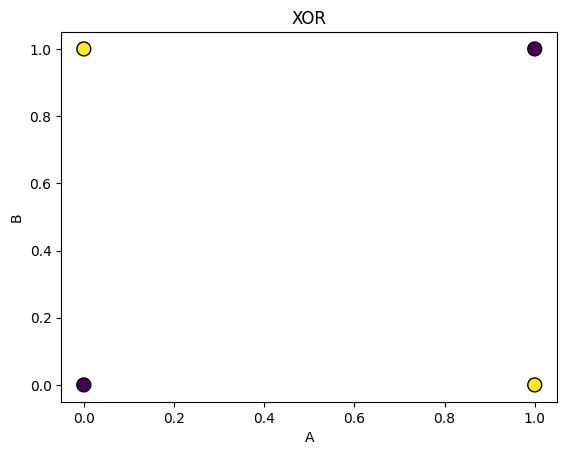

In [46]:
#데이터 시각화를 통해 XOR 문제가 무엇인지 다시 한 번 정리
plt.scatter(X[:,0], X[:,1], c =y ,edgecolor='k', s =100)
plt.xlabel('A')
plt.ylabel('B')
plt.title('XOR')
plt.show()